In [1]:
import time
start_time = time.time()

In [2]:
import pandas as pd
import numpy as np
import cv2
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

数据准备

In [3]:
# 选择图片和设置路径
target = 3
data_name = ['0618', '0854', '1066'][target - 1]

data_path = f'../RGB_data/UniformSampler_1066_3x3_multi_labelme.csv'  # 训练集
pred_path = f'./result_img/pred_{data_name}.png'  # 模型预测结果二值图
img_path = f'../input_data/{data_name}.png'  # 测试集
binary_path = f'../input_data/{data_name}_label.png'  # 测试集评估用的二值图
smoothed_path = f'./result_img/smoothed_pred_{data_name}.png'  # 光滑处理图片保存

初始化

In [4]:
# 加载数据
data = pd.read_csv(data_path)

# 提取特征和标签
features = data.drop(columns=['Label']).values  # 去掉标签列
labels = data['Label'].values

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.25, random_state=42)

训练和预测评估

In [5]:
# 训练朴素贝叶斯分类器
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# 在验证集上进行预测并做评估
y_val_pred = gnb.predict(X_val)
print("Validation dataset Evaluation:")
print(classification_report(y_val, y_val_pred))

Validation dataset Evaluation:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       168
           1       0.71      0.75      0.73        60
           2       0.91      0.86      0.88        85

    accuracy                           0.88       313
   macro avg       0.85      0.85      0.85       313
weighted avg       0.88      0.88      0.88       313



测试集上评估

In [6]:
# 读入测试集
img = cv2.imread(img_path)

In [7]:
# # Padding layer
# print(img.shape)
# img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_REFLECT, value=(0, 0, 0))
# print(img.shape)

In [8]:
# 读取图片大小
height, width, _ = img.shape
# 准备测试集特征矩阵
test_features = []

# 对测试集做同样的3x3处理方便后面按照3x3进行预测
# 对于每个像素(除去边缘)，提取周围3*3=9个像素的特征存入特征矩阵
# 每一行都是一个像素点的27个特征，这可以保证预测是对中心点进行
for y in range(1, height - 1):
    for x in range(1, width - 1):
        # 中心为(x, y)
        feature_vector = img[y-1:y+2, x-1:x+2].flatten()
        test_features.append(feature_vector)

# 将特征列表转换为NumPy数组
test_features_array = np.array(test_features)
print(test_features_array.shape)

# 在测试集上预测
y_test_pred = gnb.predict(test_features_array)

# 创建一个与原图大小相同的空白图像，初始化为全0(黑色,即背景)
segmented_img = np.zeros((height, width), dtype=np.uint8)
# 将预测结果重塑为原始图像对应大小填入数据
segmented_img[1:-1, 1:-1] = y_test_pred.reshape(height - 2, width - 2)
print(segmented_img.shape)

# 对边缘和分界点进行处理全部设置为背景
segmented_img[0, :] = segmented_img[-1, :] = 0  # 设置第一行和最后一行为0
segmented_img[:, 0] = segmented_img[:, -1] = 0  # 设置第一列和最后一列为0

(123504, 27)
(250, 500)


可视化

Test dataset Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     94267
           1       0.67      0.66      0.67     30733

    accuracy                           0.84    125000
   macro avg       0.78      0.78      0.78    125000
weighted avg       0.84      0.84      0.84    125000



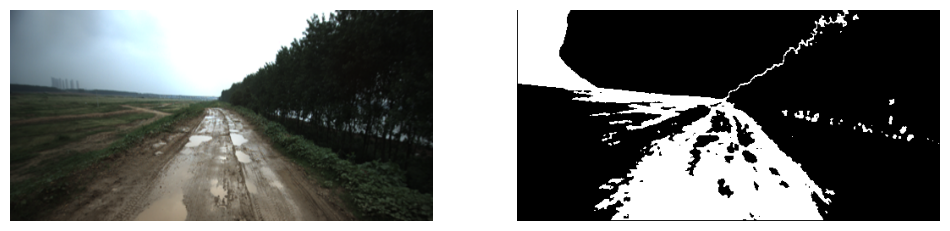

In [9]:
# 生成二值图：只有标签1（道路）为白色，其余为黑色
binary_output = np.zeros_like(segmented_img)
binary_output[segmented_img == 1] = 255  # 将道路标签染成白色

# 保存二值化预测图像
cv2.imwrite(pred_path, binary_output)

# 计算和打印测试集上的评价指标
# 读取二值化图像
binary_img = cv2.imread(binary_path, cv2.IMREAD_GRAYSCALE)
print("Test dataset Evaluation:")
print(classification_report(binary_img.flatten() // 255, binary_output.flatten() // 255))

# 显示原图和预测结果
plt.figure(figsize=(12, 6))

# 显示原图
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('')
plt.axis('off')

# 显示预测的二值图
plt.subplot(1, 2, 2)
plt.imshow(binary_output, cmap='gray')
plt.title('')
plt.axis('off')

# 显示图像
plt.show()

Smoothed Image Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     94267
           1       0.70      0.64      0.67     30733

    accuracy                           0.84    125000
   macro avg       0.79      0.77      0.78    125000
weighted avg       0.84      0.84      0.84    125000

Smoothed Confusion Matrix:
[[85786  8481]
 [11095 19638]]


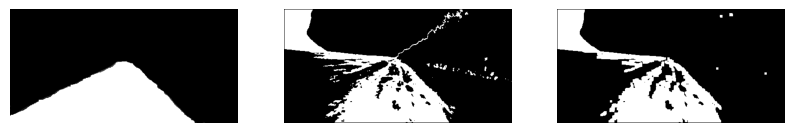

True

In [10]:
# 读取二值化图像
binary_img = cv2.imread(binary_path, cv2.IMREAD_GRAYSCALE)

# 设定结构元素大小
kernel_size = 5  # 可以根据需要调整大小
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# 进行形态学开运算
smoothed_img = cv2.morphologyEx(binary_output, cv2.MORPH_OPEN, kernel)

# 将平滑后的二值图进行评估
original_labels = binary_img.flatten() // 255  # 原始标签
smoothed_pred = smoothed_img.flatten() // 255  # 平滑后的预测图

# 确保两个数组的长度一致
if original_labels.shape[0] != smoothed_pred.shape[0]:
    print(f"Warning: Shapes mismatch! Original: {original_labels.shape[0]}, Smoothed: {smoothed_pred.shape[0]}")

# 计算和打印平滑后的评价指标
print("Smoothed Image Evaluation:")
print(classification_report(original_labels, smoothed_pred))

# 计算混淆矩阵
smoothed_conf_matrix = confusion_matrix(original_labels, smoothed_pred)
print("Smoothed Confusion Matrix:")
print(smoothed_conf_matrix)

# 显示原始二值图与处理后的图像
plt.figure(figsize=(10, 5))

# 显示原始二值图
plt.subplot(1, 3, 1)
plt.imshow(binary_img, cmap='gray')
plt.title('')
plt.axis('off')

# 显示原始二值图
plt.subplot(1, 3, 2)
plt.imshow(binary_output, cmap='gray')
plt.title('')
plt.axis('off')

# 显示平滑后的图像
plt.subplot(1, 3, 3)
plt.imshow(smoothed_img, cmap='gray')
plt.title('')
plt.axis('off')

plt.show()

# 保存平滑后的图像
cv2.imwrite(smoothed_path, smoothed_img)

In [11]:
end_time = time.time()
# 计算并打印运行时间
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 3.956763982772827 seconds
